In [0]:
!pip install flax > /dev/null 2>&1
!pip install git+git://github.com/deepmind/rlax.git > /dev/null 2>&1

In [0]:
import jax
from jax import jit, grad, vmap
import jax.numpy as jnp
from flax import nn, optim
import rlax

import gym
from functools import partial
import numpy as np

import random
from IPython.display import clear_output
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

# Hyperparameters

In [0]:
NUM_EPISODES = 5000
BATCH_SIZE   = 32
GAMMA        = 0.99

# Deep Q Network

In [0]:
class DQN(nn.Module):
  def apply(self, x, num_actions):
    x = nn.Dense(x, 128)
    x = nn.relu(x)
    x = nn.Dense(x, 128)
    x = nn.relu(x)
    y = nn.Dense(x, num_actions)
    return y

# Replay Buffer

In [0]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = jnp.expand_dims(state, 0)
        next_state = jnp.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return {'state': jnp.concatenate(state), 'action':jnp.asarray(action), 
                'reward':jnp.asarray(reward), 
                'next_state':jnp.concatenate(next_state), 'done':jnp.asarray(done)}
    
    def __len__(self):
        return len(self.buffer)

# $\epsilon$-Greedy

In [0]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * jnp.exp(-1. * frame_idx / epsilon_decay)

# Training

In [0]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [0]:
@jit
def policy(model, key, obs, epsilon):
  """Sample action from epsilon-greedy policy."""
  q = model(obs)
  a = rlax.epsilon_greedy(epsilon=epsilon).sample(key, q)
  return q, a

batched_loss = vmap(rlax.double_q_learning)
@jit
def train_step(optimizer, target_model, batch, gamma):
  def loss_fn(model):
    done = batch['done']
    q = model(batch['state'])
    q_target = target_model(batch['next_state'])
    q_selector = model(batch['next_state'])
    
    td_error = batched_loss(q, batch['action'], batch['reward'], 
                                        gamma*(1. - done), q_target, q_selector)
    return jnp.mean(rlax.l2_loss(td_error))

  loss, grad = jax.value_and_grad(loss_fn)(optimizer.target)
  optimizer = optimizer.apply_gradient(grad)
  return optimizer, loss

def main_loop():
  # Build env
  env_id = "CartPole-v0"
  env = gym.make(env_id)
  replay_buffer = ReplayBuffer(2000)

  #logging
  losses = []
  all_rewards = []
  episode_reward = 0
  key = jax.random.PRNGKey(0)

  # Build and initialize Q-network.
  num_actions = env.action_space.n
  state = env.reset()
  module = DQN.partial(num_actions=num_actions)
  _, initial_params = module.init(key, state)
  model = nn.Model(module, initial_params)
  target_model = nn.Model(module, initial_params)

  # Build and initialize optimizer.
  optimizer = optim.Adam(1e-3).create(model)

  for idx in range(1, NUM_EPISODES+1):
    key, _ = jax.random.split(key)
    epsilon = epsilon_by_frame(idx)

    #Act in the environment and update replay_buffer
    _, action = policy(optimizer.target, key, state, epsilon)  
    next_state, reward, done, _ = env.step(int(action))
    replay_buffer.push(state, action, reward, next_state, done)
    
  
    state = next_state
    episode_reward += reward

    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > BATCH_SIZE:
      batch = replay_buffer.sample(BATCH_SIZE)
      optimizer, loss = train_step(optimizer, target_model, batch, GAMMA)
      losses.append(float(loss))
        
    if idx % 200 == 0:
     plot(idx, all_rewards, losses)
      
    #Update Target model parameters
    if idx % 100 == 0:
      target_model = target_model.replace(params=optimizer.target.params)

  return optimizer.target 

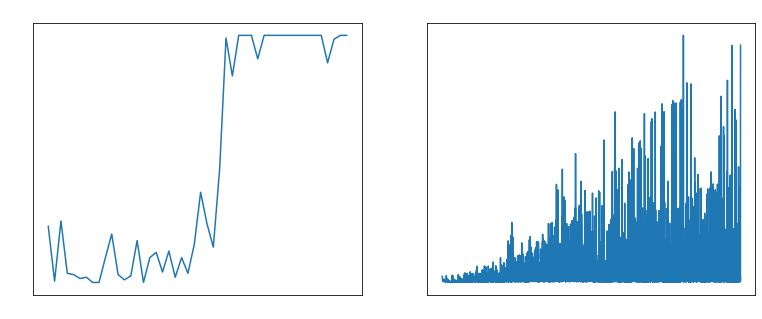

In [0]:
model = main_loop()